29


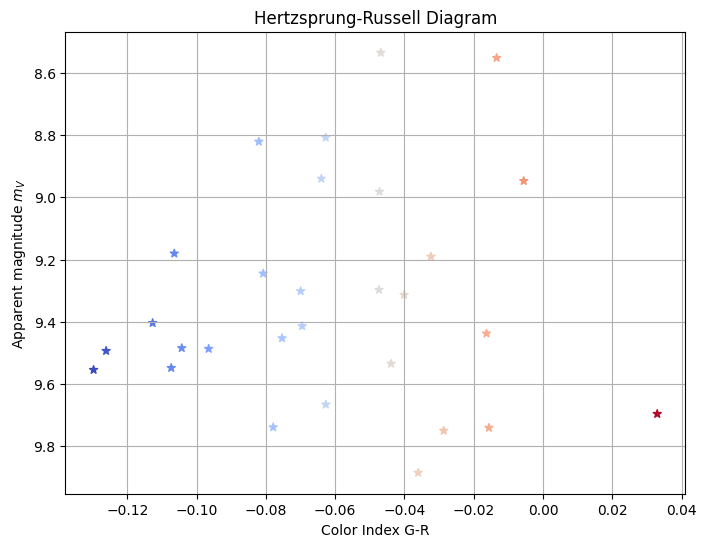

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

default_zero_point = 25.0  # Default magnitude zero point if not available in FITS header
# Load FITS file and check the header
def load_fits_image(filename):
    with fits.open(filename) as hdul:
        data = hdul[0].data  # Main image
        header = hdul[0].header
        mag_zero_point = header.get("MAGZP", default_zero_point)  # Get magnitude zero point if available
    return data, mag_zero_point


def find_stars(image, threshold=5):
    mean, std = np.mean(image), np.std(image)
    star_finder = DAOStarFinder(fwhm=3, threshold=threshold * std)
    stars = star_finder(image - mean)
    
    # Filter out stars where the intensity is greater than 60000
    valid_stars = []
    for star in stars:
        x, y = int(star['xcentroid']), int(star['ycentroid'])
        if image[y, x] <= 64000:
            valid_stars.append(star)
    
    return valid_stars

# Compute integrated intensity for each star
def compute_intensity(image, stars, radius=3):
    # positions = np.transpose((stars['xcentroid'], stars['ycentroid']))
    positions = [(star['xcentroid'], star['ycentroid']) for star in stars]
    apertures = CircularAperture(positions, r=radius)
    phot_table = aperture_photometry(image, apertures)
    return phot_table['aperture_sum']

# Main processing function
def process_fits(filename):
    image, mag_zero_point = load_fits_image(filename)
    if len(image.shape) == 3:
        stars = find_stars(image[1])  # Use the G channel to detect stars
        print(len(stars))
        intensities = []
        for i in range(len(stars)):
            star_intensity = []
            for channel in range(3):
                intensity = compute_intensity(image[channel], stars)[i]
                star_intensity.append(intensity)
            intensities.append(tuple(star_intensity))
        return intensities, mag_zero_point
    else:
        print("Error: The image does not contain RGB color channels.")
        return None, None

# Run the program
fits_filename = '/Users/Alexey_Pasechnik/Pictures/Seestar/MyWorks/M 13/M 13_crop_calibrated.fit'
# fits_filename = '/Users/Alexey_Pasechnik/Pictures/Seestar/MyWorks/M 45_mosaic/Stacked_361_mosaic_M 45_10.0s_IRCUT_20241102-215037.fit'
intensity_results, mag_zero_point = process_fits(fits_filename)
# print (fits.info(fits_filename))

# Convert RGB to G-R and M_V
G_R = [2 * (g - r) / (g + r) for r, g, b in intensity_results]
M_V = [-2.5 * np.log10(r + g + b) + mag_zero_point for r, g, b in intensity_results]

# Define colormap based on G-R index
colors = plt.cm.coolwarm((np.array(G_R) - min(G_R)) / (max(G_R) - min(G_R)))

# Plot Hertzsprung-Russell diagram
plt.figure(figsize=(8, 6))
plt.scatter(G_R, M_V, c=colors, marker='*')
plt.gca().invert_yaxis()  # Invert Y-axis as brighter stars have lower magnitudes
plt.xlabel("Color Index G-R")
plt.ylabel("Apparent magnitude $m_V$")
plt.title("Hertzsprung-Russell Diagram")
plt.grid()
plt.show()

# for i, intensities in enumerate(intensity_results):
#     print(f"Star {i+1}: R={intensities[0]}, G={intensities[1]}, B={intensities[2]}")


In [12]:
from astropy.io import fits

# Путь к вашему FITS-файлу
fits_filename = '/Users/Alexey_Pasechnik/Pictures/Seestar/MyWorks/M 45_mosaic/Stacked_361_mosaic_M 45_10.0s_IRCUT_20241102-215037.fit'

# Открываем FITS-файл
with fits.open(fits_filename) as hdul:
    # Получаем заголовок и данные первого HDU
    header = hdul[0].header
    data = hdul[0].data

    # Выводим полный заголовок для проверки BSCALE, BZERO, BITPIX
    print("Full header:")
    print(header)

    # Проверяем BITPIX, BSCALE, и BZERO
    bitpix = header.get('BITPIX', 16)  # По умолчанию 16, если не указано
    bscale = header.get('BSCALE', 1.0)  # По умолчанию 1
    bzero = header.get('BZERO', 0.0)    # По умолчанию 0

    print("\nExtracted header data:")
    print(f"BITPIX: {bitpix}, BSCALE: {bscale}, BZERO: {bzero}")

    # Проверяем размеры изображения
    if data.ndim == 3:  # Если есть 3 канала (RGB)
        height, width, channels = data.shape
    else:
        raise ValueError("Data does not have 3 dimensions (RGB channels).")

    # Выводим сырые данные (до применения BSCALE и BZERO)
    # astropy обычно уже применяет BSCALE и BZERO, но мы можем восстановить сырые данные
    raw_data = data.astype('>u2')  # Предполагаем big-endian для Uint16 (FITS использует big-endian)

    # Выводим первые три значения сырых данных (R, G, B для точки (0,0))
    raw_sample = [
        raw_data[0, 0, 0],  # R-канал
        raw_data[1, 0, 0],  # G-канал
        raw_data[2, 0, 0]   # B-канал
    ]
    print("\nRaw data sample (first 3 values, R,G,B at 0,0):", raw_sample)

    # Выводим первые 10 значений G-канала для сравнения
    g_channel_first_values = raw_data[1, 0, :10].tolist()
    print("First values of G channel (first 10):", g_channel_first_values)

    # Выводим структуру данных
    print("Image structure (channels, height, width):", data.shape)

Full header:
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    3 / number of data axes                            NAXIS1  =                 1836 / length of data axis 1                          NAXIS2  =                 3264 / length of data axis 2                          NAXIS3  =                    3 / length of data axis 3                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H BZERO   =                32768 / offset data range to that of unsigned short    BSCALE  =                    1 / default scaling factor                         CREATOR = 'ZWO Seestar S50'    / Capture software                               PRODUCER= 'ZWO     '       